In [59]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

# define path to save model
model_path = './Output/binary_model.h5'

##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('./PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('./PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('./PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

##################################
# Data Preprocessing
##################################

#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)


# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

##################################
# LSTM
##################################

# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used."""
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols_paper = ['s7','s8','s9','s12','s16','s17','s20']
sequence_cols.extend(sensor_cols)
# sequence_cols = sequence_cols_paper

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape
# 
label_gen_rul = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array_rul = np.concatenate(label_gen_rul).astype(np.float32)


D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [60]:
seq_array_test_last = (list(gen_sequence(test_df[test_df['id']==id], sequence_length, sequence_cols)) 
           for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) > sequence_length)
seq_array_test_last = np.concatenate(list(seq_array_test_last)).astype(np.float32)


# Prepare Dataset

In [61]:


# Similarly, we pick the labels

#print("y_mask")
# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
label_array_test_last = [gen_labels(test_df[test_df['id']==id], sequence_length, ['label1']) 
             for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) > sequence_length]

label_array_test_last = np.concatenate(label_array_test_last).astype(np.float32)

# RUL 
rul_array_test_last = [gen_labels(test_df[test_df['id']==id], sequence_length, ['RUL']) 
             for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) > sequence_length]

rul_array_test_last = np.concatenate(rul_array_test_last).astype(np.float32)
rul_array_test_last.shape




(8162, 1)

# Define and train Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None
Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 61s - loss: 0.2639 - acc: 0.8902 - val_loss: 0.1500 - val_acc: 0.9412


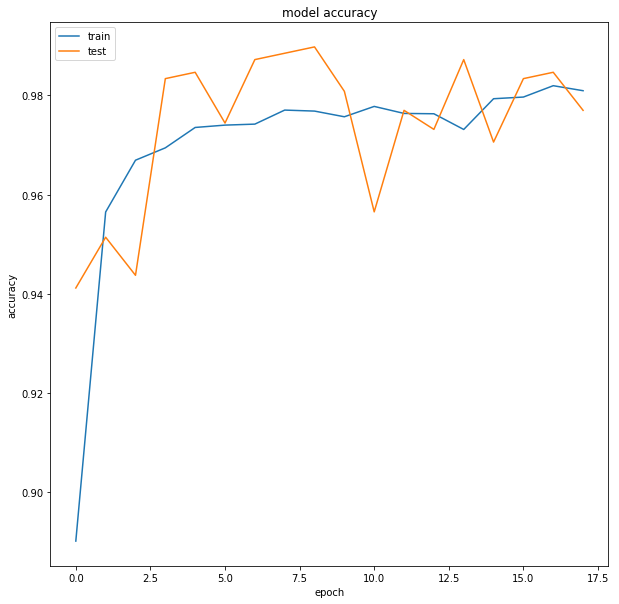

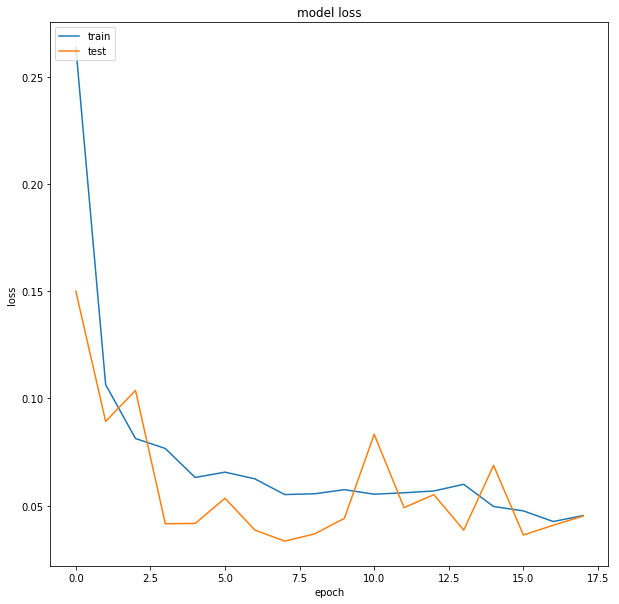

15631/15631 [==============================] - 9s 583us/step
Accurracy: 0.9813831551855474
15631/15631 [==============================] - 10s 660us/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12483    48]
 [  243  2857]]
precision =  0.9834767641996558 
 recall =  0.9216129032258065


In [62]:
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

modelclassification = Sequential()

modelclassification.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
modelclassification.add(Dropout(0.2))

modelclassification.add(LSTM(
          units=50,
          return_sequences=False))
modelclassification.add(Dropout(0.2))

modelclassification.add(Dense(units=nb_out, activation='sigmoid'))
modelclassification.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(modelclassification.summary())

# fit the network
history = modelclassification.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_loss.png")

# training metrics
scores = modelclassification.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = modelclassification.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('./Output/binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

In [63]:
seq_array_test_last.shape

(8162, 50, 25)

# View result of classfication model , From ROC-AUC Select threshold available. 

In [64]:
X = label_array_rul
Y = label_array

proba = modelclassification.predict(seq_array)

In [65]:
proba

array([[9.5367432e-06],
       [9.7453594e-06],
       [1.0073185e-05],
       ...,
       [9.9988222e-01],
       [9.9988854e-01],
       [9.9989414e-01]], dtype=float32)

In [66]:
X0 = X[Y==0]
y0 = Y[Y==0]
X1 = X[Y==1]
y1 = Y[Y==1]

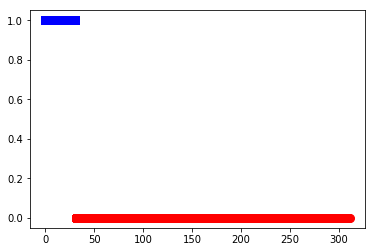

In [67]:
plt.plot(X0, y0, 'ro', markersize = 8) # Blue is precdict label 1
plt.plot(X1, y1, 'bs', markersize = 8) # Red is preict label 0
# xx = X
# w0 = w[-1][0][0]
# w1 = w[-1][1][0]
# threshold = -w0/w1
# yy = proba
# plt.axis([-2, 8, -1, 2])
# plt.plot(xx, yy, 'g-', linewidth = 2)
# # plt.plot(threshold, .5, 'y^', markersize = 8)
# plt.xlabel('studying hours')
# plt.ylabel('predicted probability of pass')
# plt.show()

# Visualization ROC-AUC of Model Train

In [68]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y, proba, pos_label = 1)
print('Thresholds:')
print(thresholds)

Thresholds:
[1.9999087e+00 9.9990875e-01 9.9990296e-01 ... 4.0829182e-06 4.0531158e-06
 3.9935112e-06]


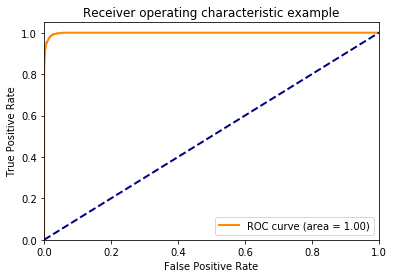

In [69]:
import matplotlib.pyplot as plt
from itertools import cycle
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [70]:
threshold_final = thresholds[tpr==1].max()
threshold_final

0.022883385

In [71]:
# Predict MOdel Classification and prepare data for LSTM Regression Model

In [72]:
def prediction(scores,threshold):
    label = []
    
    for i in scores: 
        if (i[0]<threshold):
            label.append([0])
        else:
            label.append([1])
    label = np.array(label)
    return label

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[7510  320]
 [   0  332]]
Precision:  0.50920245398773 
 Recall:  1.0 
 F1-score: 0.6747967479674797


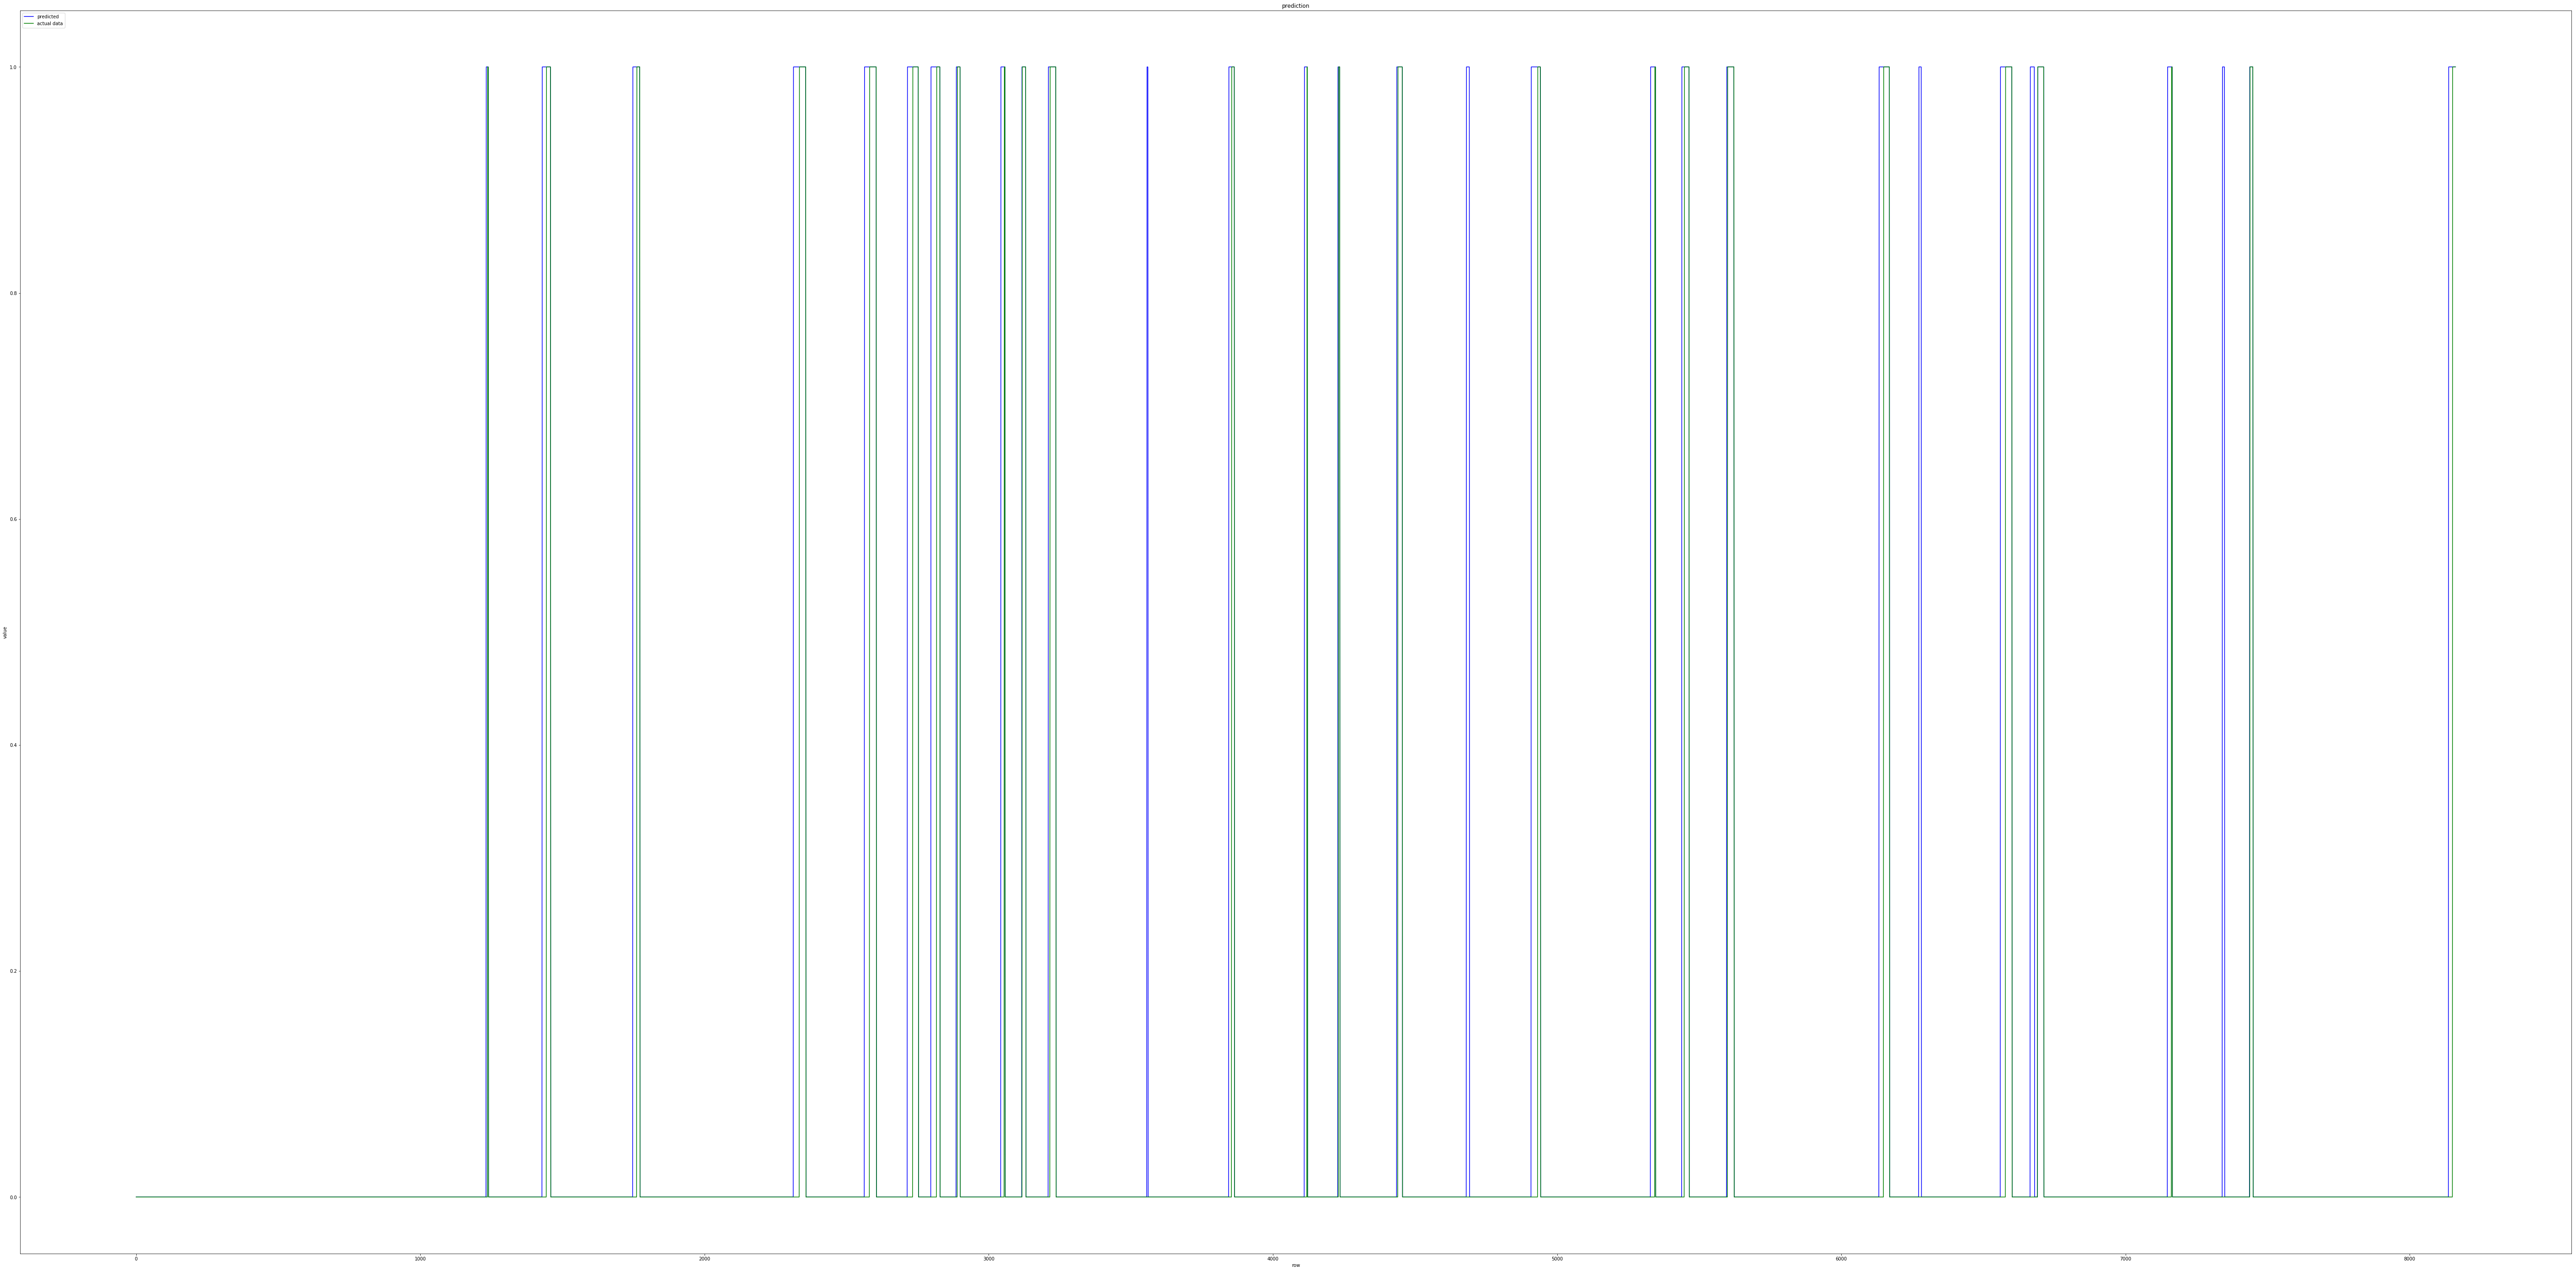

In [73]:
##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data



# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# test metrics
# scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
# print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = prediction(estimator.predict(seq_array_test_last),threshold_final)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Output/binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(100, 50))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("./Output/model_verify.png")

In [74]:
print(confusion_matrix(y_true_test,y_pred_test))

[[7510  320]
 [   0  332]]


# Lựa chọn các test set data với predict từ bài toán classification. 

In [75]:
rul_array_test_last = rul_array_test_last[list(map(bool,y_pred_test))]
seq_array_test_last = seq_array_test_last[list(map(bool,y_pred_test))]



# Define and train LSTM Regression

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50, 100)           50400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None
T

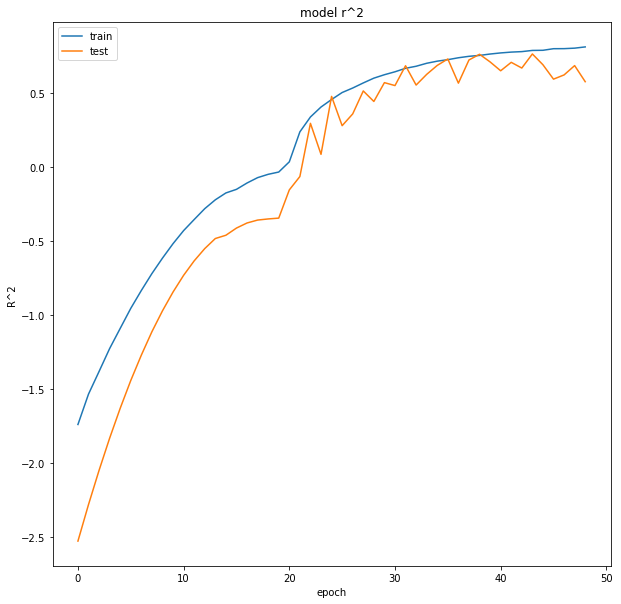

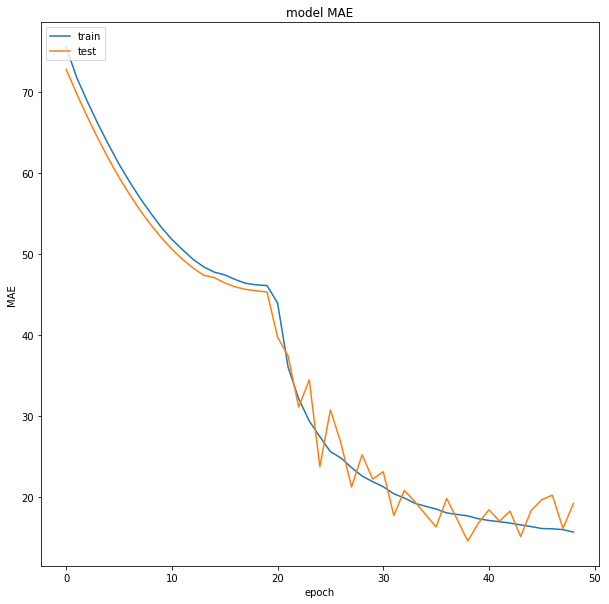

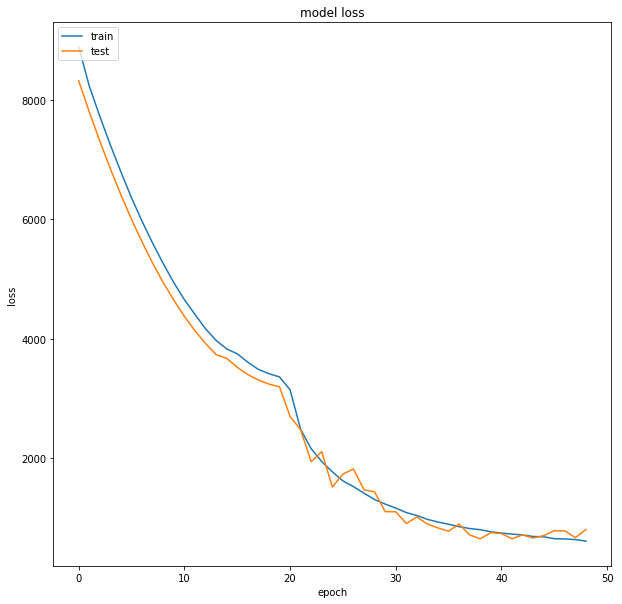

15631/15631 [==============================] - 14s 892us/step

MAE: 15.094619245692686

R^2: 0.7565428005185498


In [76]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing



# define path to save model
model_path = './Output/regression_model.h5'

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array_rul.shape[1]

modelRegression = Sequential()
modelRegression.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
modelRegression.add(Dropout(0.2))
modelRegression.add(LSTM(
          units=50,
          return_sequences=False))
modelRegression.add(Dropout(0.2))
modelRegression.add(Dense(units=nb_out))
modelRegression.add(Activation("linear"))
modelRegression.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(modelRegression.summary())

# fit the network
history = modelRegression.fit(seq_array, label_array_rul, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_regression_loss.png")

# training metrics
scores  = modelRegression.evaluate(seq_array, label_array_rul, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))



In [77]:
scores  = modelRegression.evaluate(seq_array, label_array, verbose=1, batch_size=200)
scores

15631/15631 [==============================] - 12s 750us/step


[10352.978747116185, 86.97221136236517, -520269466662.93414]

In [78]:
y_pred = modelRegression.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('./Output/submit_train.csv', index = None)

15631/15631 [==============================] - 12s 795us/step



MAE: 4.351491827906275

R^2: 0.5781761192105299


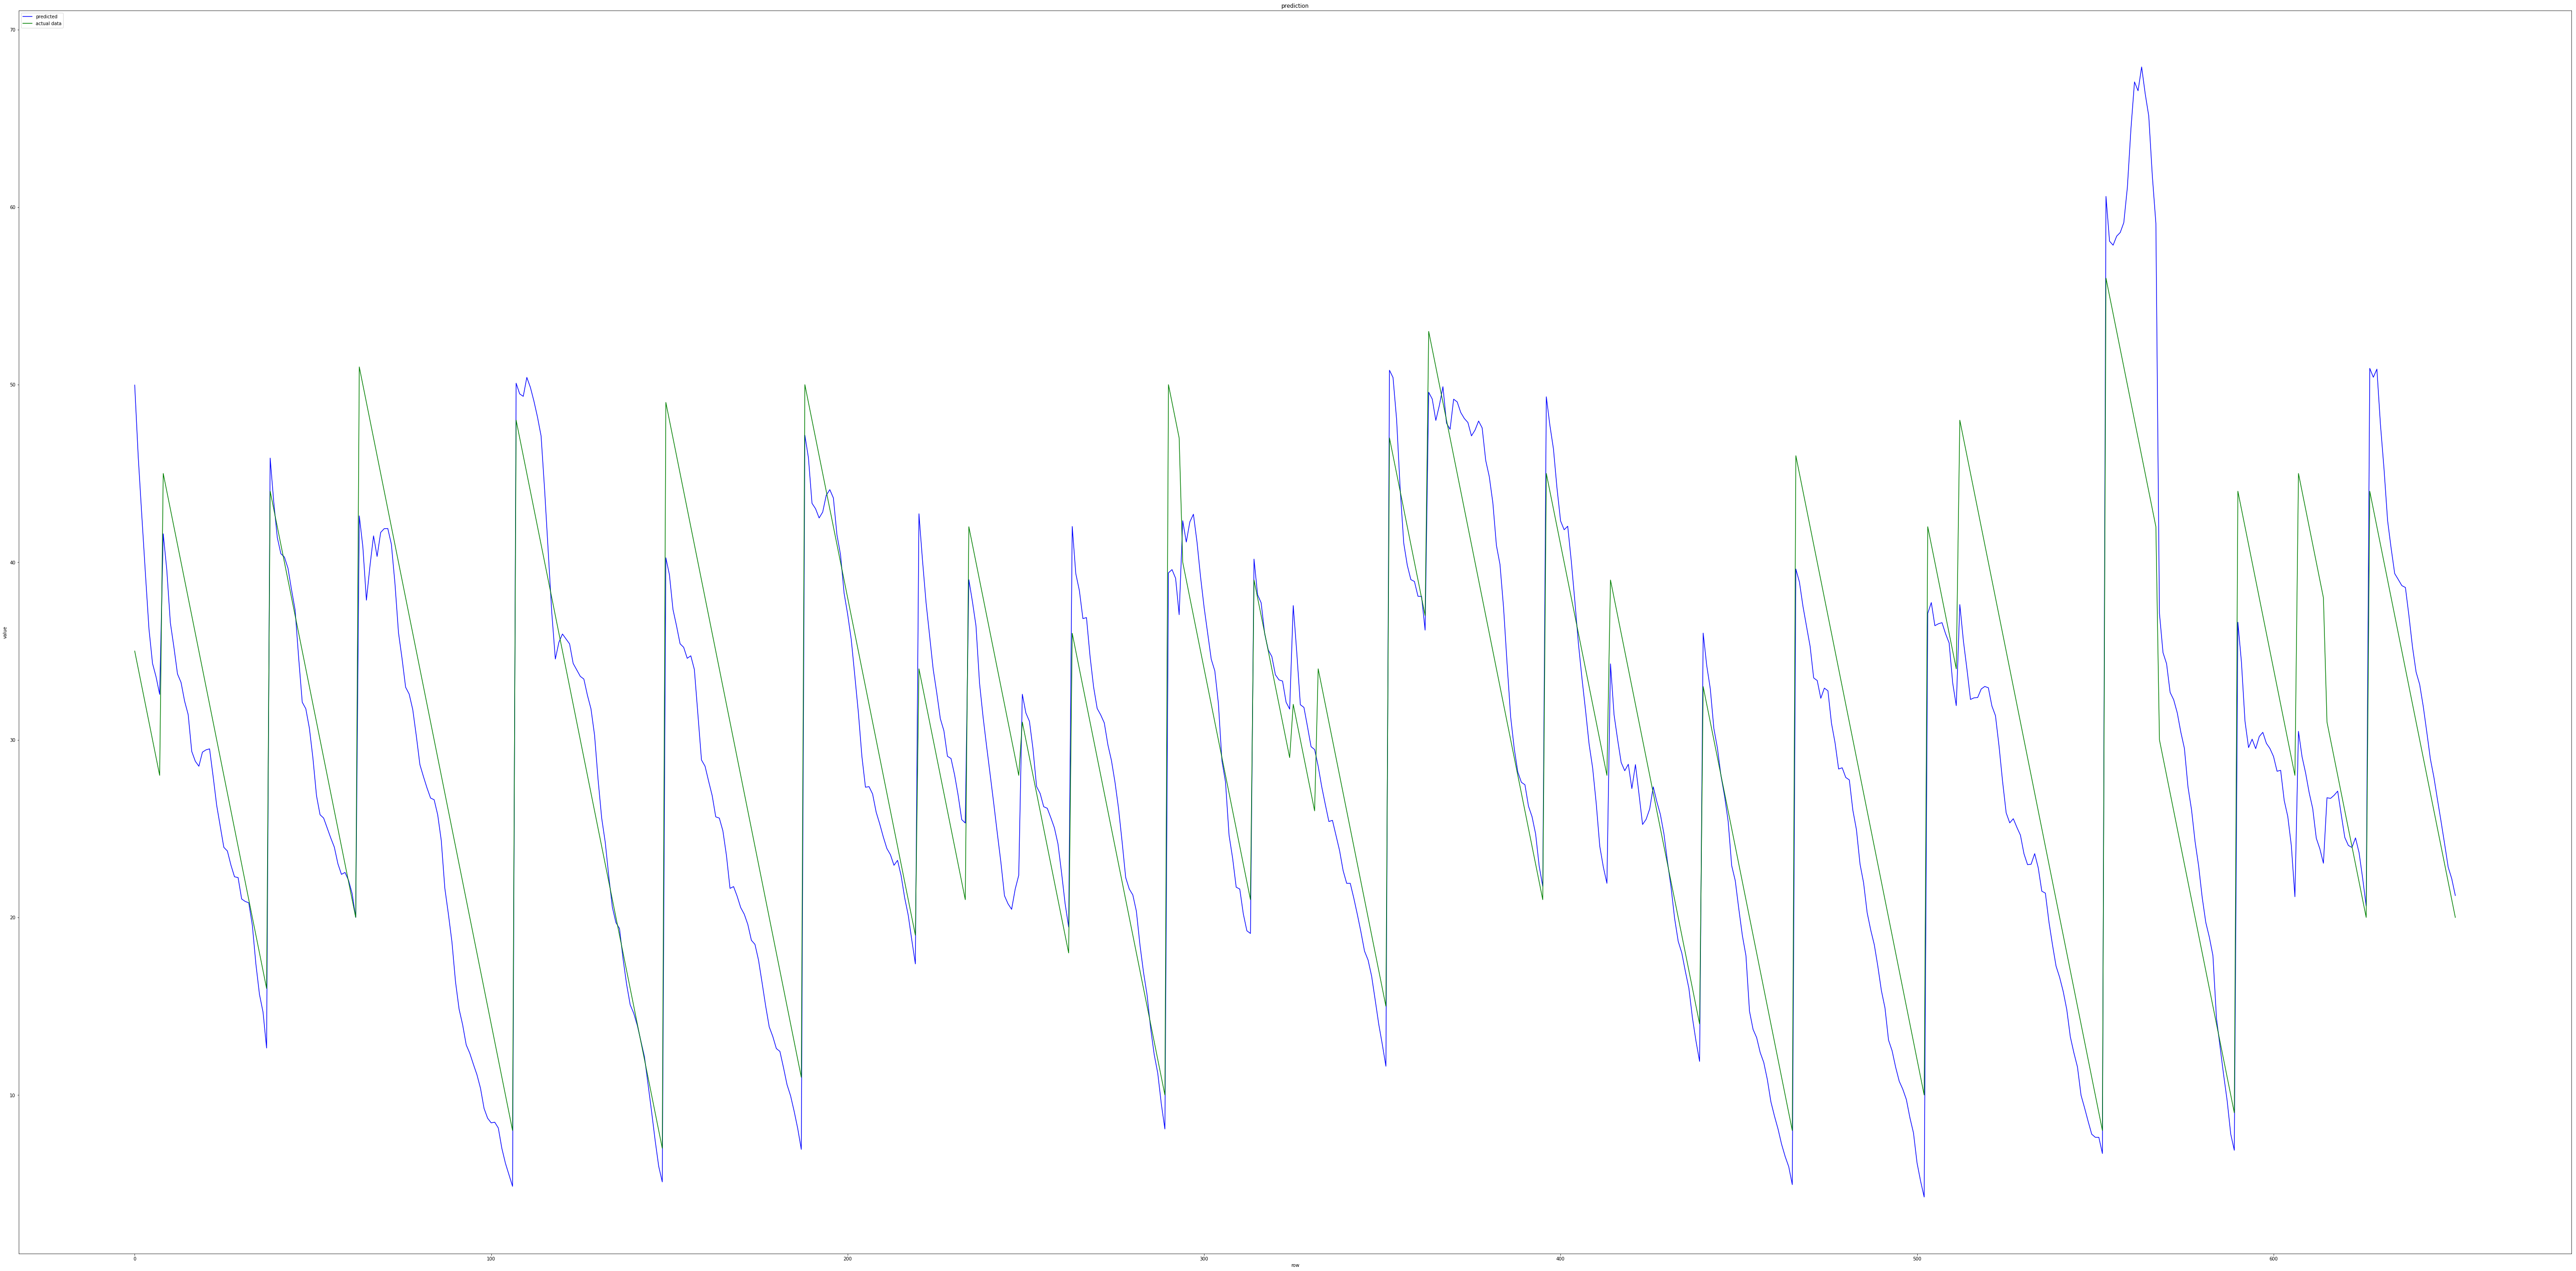

In [79]:

if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, rul_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = rul_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('./Output/submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(100, 50))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("./Output/model_regression_verify.png")

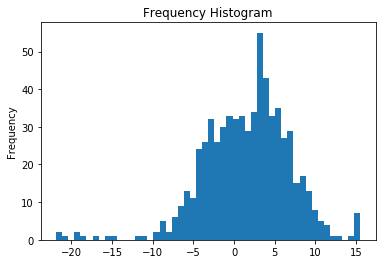

In [80]:
x = y_true_test
y = y_pred_test

plt.hist(x-y, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [81]:
# (y_true_test - y_pred_test)

In [82]:
# y_true_test

In [83]:
from datetime import datetime
d = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [84]:
model_json = modelRegression.to_json()
with open("lstm_regression_"+d+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelRegression.save_weights("lstm_regression.h5")
print("Saved model to disk")

Saved model to disk


In [85]:
model_jsonclass = modelclassification.to_json()
with open("lstm_classification_."+d+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelclassification.save_weights("lstm_classification.h5")
print("Saved model to disk")

Saved model to disk
